In [1]:
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras
from keras.utils import normalize
from keras.metrics import MeanIoU
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Segmentation Models: using `keras` framework.


In [2]:
SIZE_X = 448
SIZE_Y = 448
n_classes=10 
train_images = []
for directory_path in glob.glob("C:/Users/KIIT/OneDrive/Desktop/Vedant_Official/vedant projects and works/Datasets/Organ_segmentation_dataset/abdominal_US/abdominal_US/AUS/images/train/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 1)
        img = cv2.resize(img, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
        train_images.append(img)
train_images = np.array(train_images)
train_masks = []
for directory_path in glob.glob("C:/Users/KIIT/OneDrive/Desktop/Vedant_Official/vedant projects and works/Datasets/Organ_segmentation_dataset/abdominal_US/abdominal_US/AUS/annotations/train/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  
        train_masks.append(mask)
train_masks = np.array(train_masks)


In [3]:
print((train_images[0].shape))
print(len(train_masks))

(448, 448, 3)
633


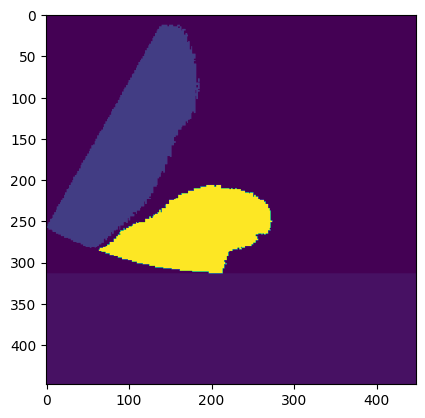

In [47]:
plt.imshow(train_masks[2])
plt.show()

In [4]:
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [ ]:
print(train_masks_encoded_original_shape.shape)
n_classes=10

In [5]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)
print("Class values in the dataset are = ", np.unique(y_train))
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


Class values in the dataset are =  [0 1 2 3 4 5 6 7 8 9]


In [ ]:
n_classes=10
activation='softmax'
LR = 0.0001
optim = keras.optimizers.Adam(LR)
total_loss = sm.losses.categorical_focal_dice_loss
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [6]:
import sys
print(n_classes)
print(X_train.shape)
print(y_train_cat.shape)
print(X_test.shape)
print(y_test_cat.shape)
for var_name, var in locals().items():
    if(sys.getsizeof(var)>10000):
        print(f"{var_name}: {sys.getsizeof(var)} bytes")

10
(569, 448, 448, 3)
(569, 448, 448, 10)
(64, 448, 448, 3)
(64, 448, 448, 10)


RuntimeError: dictionary changed size during iteration

In [ ]:
import gc
del train_images
del mask
del img
del train_masks
del train_masks_reshaped_encoded
gc.collect()

In [7]:
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)
print(X_train1.shape)
print(X_test1.shape)


(569, 448, 448, 3)
(64, 448, 448, 3)


In [ ]:
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)
model1.compile(optim, total_loss, metrics=metrics)

history1=model1.fit(X_train1,
          y_train_cat,
          batch_size=8,
          epochs=50,
          verbose=1,
          validation_data=(X_test1, y_test_cat))
model1.save('organ_segment_50epochs.hdf5')

In [ ]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()


In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from keras.models import load_model
from keras.metrics import MeanIoU
model1 = load_model('res34_backbone_50epochs.hdf5', compile=False)
y_pred1=model1.predict(X_test1)
y_pred1_argmax=np.argmax(y_pred1, axis=3)
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax)
confusion_matrix = IOU_keras.total_cm.numpy()
iou_per_class = []
for i in range(n_classes):
    true_positives = confusion_matrix[i, i]
    false_positives = np.sum(confusion_matrix[:, i]) - true_positives
    false_negatives = np.sum(confusion_matrix[i, :]) - true_positives
    denominator = true_positives + false_positives + false_negatives
    if denominator == 0:
        iou = 0.0
    else:
        iou = true_positives / denominator
    iou_per_class.append(iou)

iou_per_class = np.array(iou_per_class)
print("IoU per class:")
print(iou_per_class)


2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 12s/step
IoU per class:
[0.93989277 0.99986833 0.12842235 0.8851896  0.61670715 0.4238947
 0.89149284 0.         0.6783811  0.40901127]


(448, 448, 1)
(1, 448, 448, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


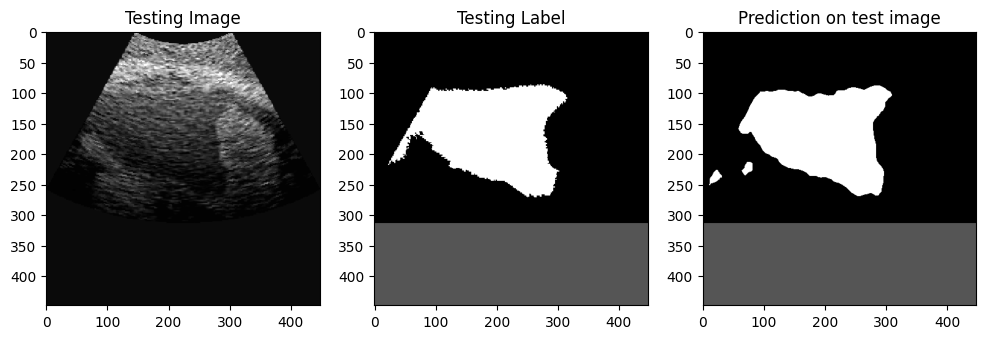

In [21]:
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
print(ground_truth.shape)
test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input1(test_img_input)
print(test_img_input1.shape)
test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()

In [12]:
test_images = []
SIZE_X = 448
SIZE_Y = 448
path=r'C:\Users\KIIT\OneDrive\Desktop\Vedant_Official\vedant projects and works\Datasets\Organ_segmentation_dataset\abdominal_US\abdominal_US\RUS\images_new'
for directory_path in glob.glob(path):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, 1)
        img = cv2.resize(img, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
        test_images.append(img)
test_images = np.array(test_images)
test_mask=[]
path_mask=r'C:\Users\KIIT\OneDrive\Desktop\Vedant_Official\vedant projects and works\Datasets\Organ_segmentation_dataset\abdominal_US\abdominal_US\RUS\annot_new'
for directory_path in glob.glob(path_mask):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
        test_mask.append(img)
test_mask = np.array(test_mask)

In [13]:
print(test_images.shape)
print(test_mask.shape)

(60, 448, 448, 3)
(60, 448, 448)


In [22]:
from keras.models import load_model
model1 = load_model('res34_backbone_50epochs.hdf5', compile=False)
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)
test_mask_input = np.expand_dims(test_mask, axis=3)
y_test1=test_mask_input
test_images=preprocess_input1(test_images)

60
57
(448, 448, 1)
(1, 448, 448, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


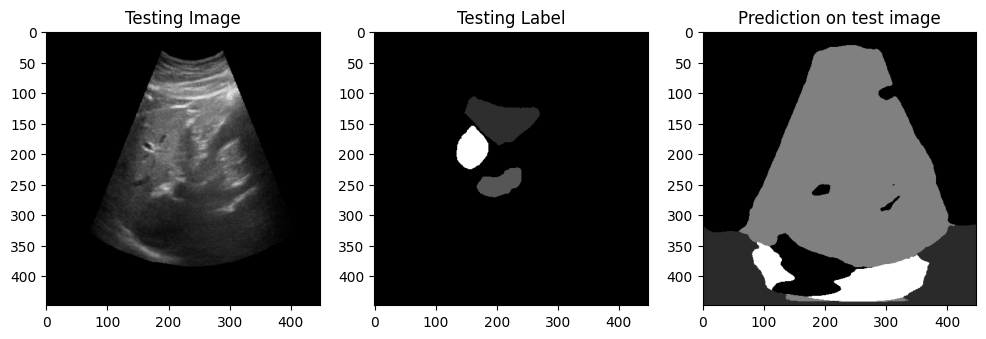

In [29]:
import random
print(len(test_images))
test_img_number = random.randint(0, len(test_images)-1)
print(test_img_number)
test_img = test_images[test_img_number]
ground_truth=y_test1[test_img_number]
print(ground_truth.shape)
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
test_img_input1 = preprocess_input1(test_img_input)
test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()

In [53]:
def replace_extension(filename, old_ext, new_ext):
    if filename.endswith(old_ext):
        return filename[:-len(old_ext)] + new_ext
    return filename

In [54]:
import os
import shutil

# Define the folder paths
annotation_folder = r"C:\Users\KIIT\OneDrive\Desktop\Vedant_Official\vedant projects and works\Datasets\Organ_segmentation_dataset\abdominal_US\abdominal_US\RUS\annotations\test"
images_folder_test = r"C:\Users\KIIT\OneDrive\Desktop\Vedant_Official\vedant projects and works\Datasets\Organ_segmentation_dataset\abdominal_US\abdominal_US\RUS\images\test"
images_folder_train = r"C:\Users\KIIT\OneDrive\Desktop\Vedant_Official\vedant projects and works\Datasets\Organ_segmentation_dataset\abdominal_US\abdominal_US\RUS\images\train"
annot_new_folder = r'C:\Users\KIIT\OneDrive\Desktop\Vedant_Official\vedant projects and works\Datasets\Organ_segmentation_dataset\abdominal_US\abdominal_US\RUS\annot_new'
images_new_folder = r'C:\Users\KIIT\OneDrive\Desktop\Vedant_Official\vedant projects and works\Datasets\Organ_segmentation_dataset\abdominal_US\abdominal_US\RUS\images_new'

# Create new directories if they don't exist
os.makedirs(annot_new_folder, exist_ok=True)
os.makedirs(images_new_folder, exist_ok=True)

# Iterate through the masks in the annotation folder
for mask_filename in os.listdir(annotation_folder):
    mask_path = os.path.join(annotation_folder, mask_filename)
    # print(mask_path)
    # Ensure the path is a file
    if os.path.isfile(mask_path):
        # Assume the image filename is the same as the mask filename
        image_filename = replace_extension(mask_filename, '.png', '.jpg')
        image_path_test = os.path.join(images_folder_test, image_filename)
        print(image_path_test)
        image_path_train = os.path.join(images_folder_train, image_filename)
        
        # Check if the corresponding image exists
        if os.path.isfile(image_path_test):
            print(image_path_test)
            # Copy the mask to the new annotation directory
            shutil.copy(mask_path, annot_new_folder)
            
            # Copy the corresponding image to the new images directory
            shutil.copy(image_path_test, images_new_folder)
        if os.path.isfile(image_path_train):
            print(image_path_train)
            # Copy the mask to the new annotation directory
            shutil.copy(mask_path, annot_new_folder)
            
            # Copy the corresponding image to the new images directory
            shutil.copy(image_path_train, images_new_folder)

print("Files have been copied to new directories.")


C:\Users\KIIT\OneDrive\Desktop\Vedant_Official\vedant projects and works\Datasets\Organ_segmentation_dataset\abdominal_US\abdominal_US\RUS\images\test\a15.jpg
C:\Users\KIIT\OneDrive\Desktop\Vedant_Official\vedant projects and works\Datasets\Organ_segmentation_dataset\abdominal_US\abdominal_US\RUS\images\test\a15.jpg
C:\Users\KIIT\OneDrive\Desktop\Vedant_Official\vedant projects and works\Datasets\Organ_segmentation_dataset\abdominal_US\abdominal_US\RUS\images\test\a2.jpg
C:\Users\KIIT\OneDrive\Desktop\Vedant_Official\vedant projects and works\Datasets\Organ_segmentation_dataset\abdominal_US\abdominal_US\RUS\images\test\a2.jpg
C:\Users\KIIT\OneDrive\Desktop\Vedant_Official\vedant projects and works\Datasets\Organ_segmentation_dataset\abdominal_US\abdominal_US\RUS\images\test\a22.jpg
C:\Users\KIIT\OneDrive\Desktop\Vedant_Official\vedant projects and works\Datasets\Organ_segmentation_dataset\abdominal_US\abdominal_US\RUS\images\test\a22.jpg
C:\Users\KIIT\OneDrive\Desktop\Vedant_Official\v